In [1]:
import json
import math
import os
os.environ['KERAS_BACKEND']='tensorflow'                     #Added by ljw 2019.12.15

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

Using TensorFlow backend.


In [2]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_ori = np.array(Dataset_loader(r'I:\lyc\dataset2\benign_ori\benign',224))
malignant_ori = np.array(Dataset_loader(r'I:\lyc\dataset2\malignant_ori',224))  

100%|██████████████████████████████████████| 1485/1485 [00:17<00:00, 84.50it/s]


<BarContainer object of 2 artists>

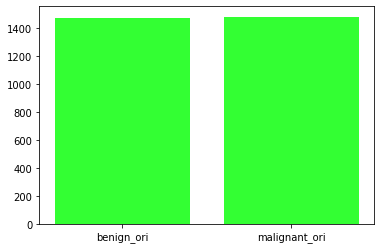

In [3]:
x_data=['benign_ori','malignant_ori']
y_data=[benign_ori.shape[0],malignant_ori.shape[0]]

plt.bar(x=x_data, height=y_data, label='乳腺癌图片原始数据大小分布', color='lime', alpha=0.8)

In [4]:
# Attach Labels
benign_ori_label = np.zeros(len(benign_ori))
malignant_ori_label = np.ones(len(malignant_ori))

In [5]:
# Train test split benign
x_train_benign, x_test_benign, y_train_benign, y_test_benign = train_test_split(
    benign_ori, benign_ori_label, 
    test_size=0.2, 
    random_state=11
)

In [6]:
print(x_train_benign.shape)
print(x_test_benign.shape)
print(y_train_benign.shape)
print(y_test_benign.shape)

(1178, 224, 224, 3)
(295, 224, 224, 3)
(1178,)
(295,)


In [7]:
# Train test split malignant
x_train_malignant, x_test_malignant, y_train_malignant, y_test_malignant = train_test_split(
    malignant_ori, malignant_ori_label, 
    test_size=0.2, 
    random_state=11
)

In [8]:
print(x_train_malignant.shape)
print(x_test_malignant.shape)
print(y_train_malignant.shape)
print(y_test_malignant.shape)

(1185, 224, 224, 3)
(297, 224, 224, 3)
(1185,)
(297,)


In [9]:
# Merge data

X_train = np.concatenate((x_train_benign, x_train_malignant), axis = 0)
Y_train = np.concatenate((y_train_benign, y_train_malignant), axis = 0)
X_test = np.concatenate((x_test_benign, x_test_malignant), axis = 0)
Y_test = np.concatenate((y_test_benign, y_test_malignant), axis = 0)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2363, 224, 224, 3)
(2363,)
(592, 224, 224, 3)
(592,)


In [11]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [12]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [13]:
# Train validaton split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

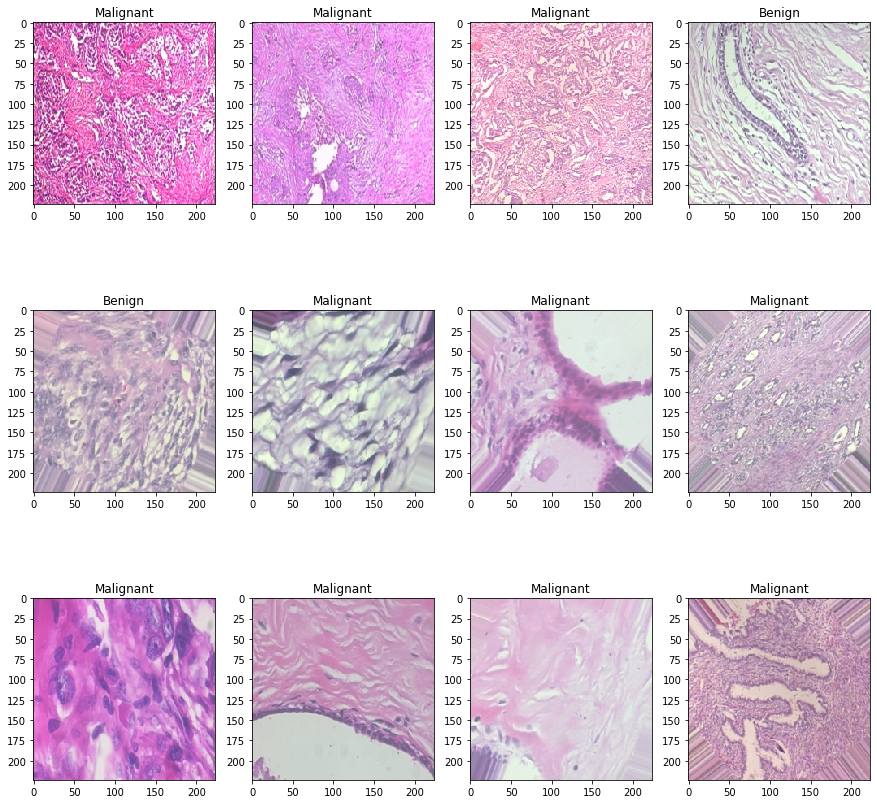

In [14]:
# Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [15]:
# BATCH_SIZE = 16

# Using original generator
# train_generator = ImageDataGenerator(
#         zoom_range=2,  # set range for random zoom
#         rotation_range = 90,
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True,  # randomly flip images
#     )

In [16]:
BATCH_SIZE = 16

In [17]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [18]:
K.clear_session()
gc.collect()

resnet = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()















  9822208/219055592 [>.............................] - ETA: 1:44:2 - ETA: 1:43:3 - ETA: 1:23:3 - ETA: 1:57:0 - ETA: 2:05:3 - ETA: 2:36:2 - ETA: 2:28:1 - ETA: 2:22:2 - ETA: 2:30:0 - ETA: 2:33:1 - ETA: 2:33:2 - ETA: 2:37:2 - ETA: 2:39:4 - ETA: 2:40:5 - ETA: 2:40:0 - ETA: 2:42:5 - ETA: 2:39:2 - ETA: 2:35:3 - ETA: 2:40:2 - ETA: 2:40:1 - ETA: 2:39:5 - ETA: 2:39:3 - ETA: 2:37:1 - ETA: 2:40:5 - ETA: 2:40:5 - ETA: 2:37:3 - ETA: 2:39:1 - ETA: 2:44:2 - ETA: 2:45:4 - ETA: 2:52:0 - ETA: 2:51:3 - ETA: 2:57:0 - ETA: 2:56:2 - ETA: 2:56:0 - ETA: 2:59:4 - ETA: 3:02:5 - ETA: 3:04:5 - ETA: 3:06:3 - ETA: 3:09:3 - ETA: 3:11:0 - ETA: 3:11:2 - ETA: 3:14:2 - ETA: 3:15:5 - ETA: 3:18:2 - ETA: 3:19:4 - ETA: 3:19:5 - ETA: 3:31:1 - ETA: 3:33:1 - ETA: 3:34:2 - ETA: 3:31:1 - ETA: 3:31:1 - ETA: 3:32:0 - ETA: 3:31:5 - ETA: 3:30:5 - ETA: 3:29:5 - ETA: 3:29:4 - ETA: 3:30:3 - ETA: 3:28:4 - ETA: 3:27:4 - ETA: 3:28:3 - ETA: 3:26:5 - ETA: 3:27:3 - ETA: 3:28:4 - ETA: 3:28:3 - ETA: 3:27:0 - ETA: 3:24:4 - ETA: 3:

In [19]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [20]:
history = model.fit(
    x_train, 
    y_train,
    batch_size=16,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)



Train on 1890 samples, validate on 473 samples
Epoch 1/20
1890/1890 [==============================] - ETA: 1:59:43 - loss: 0.9864 - acc: 0.62 - ETA: 1:07:02 - loss: 1.1222 - acc: 0.50 - ETA: 49:33 - loss: 1.0248 - acc: 0.5417 - ETA: 40:41 - loss: 1.0094 - acc: 0.54 - ETA: 35:14 - loss: 1.0853 - acc: 0.51 - ETA: 31:40 - loss: 1.0347 - acc: 0.53 - ETA: 29:02 - loss: 1.0367 - acc: 0.53 - ETA: 27:05 - loss: 1.0109 - acc: 0.53 - ETA: 25:29 - loss: 0.9407 - acc: 0.56 - ETA: 24:13 - loss: 0.9710 - acc: 0.56 - ETA: 23:06 - loss: 0.9860 - acc: 0.56 - ETA: 22:10 - loss: 0.9819 - acc: 0.55 - ETA: 21:22 - loss: 0.9671 - acc: 0.55 - ETA: 20:38 - loss: 0.9334 - acc: 0.56 - ETA: 19:59 - loss: 0.9182 - acc: 0.57 - ETA: 19:25 - loss: 0.9271 - acc: 0.58 - ETA: 18:55 - loss: 0.8977 - acc: 0.59 - ETA: 18:26 - loss: 0.9372 - acc: 0.58 - ETA: 17:59 - loss: 0.9256 - acc: 0.59 - ETA: 17:33 - loss: 0.9108 - acc: 0.60 - ETA: 17:10 - loss: 0.8914 - acc: 0.61 - ETA: 16:50 - loss: 0.8733 - acc: 0.61 - ETA: 16:3

In [21]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

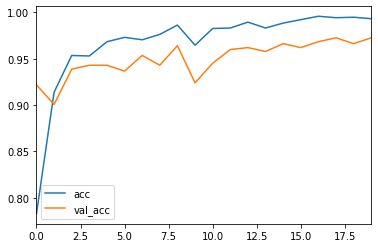

In [22]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

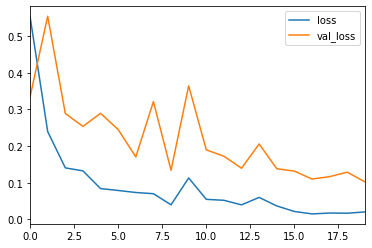

In [23]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [24]:
model.load_weights("weights.best.hdf5")

In [25]:
Y_val_pred = model.predict(x_val)

In [26]:
Y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[222  73]
 [  8 289]]


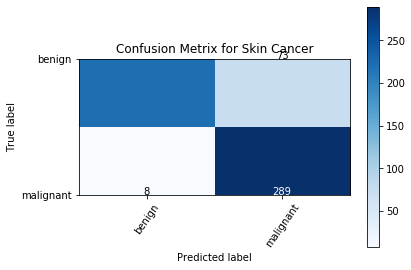

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [28]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85       295
           1       0.80      0.97      0.88       297

    accuracy                           0.86       592
   macro avg       0.88      0.86      0.86       592
weighted avg       0.88      0.86      0.86       592



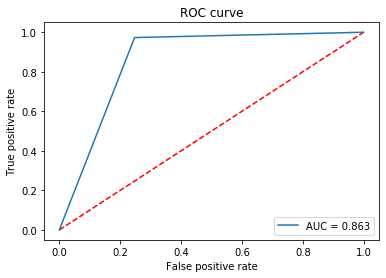

In [29]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()


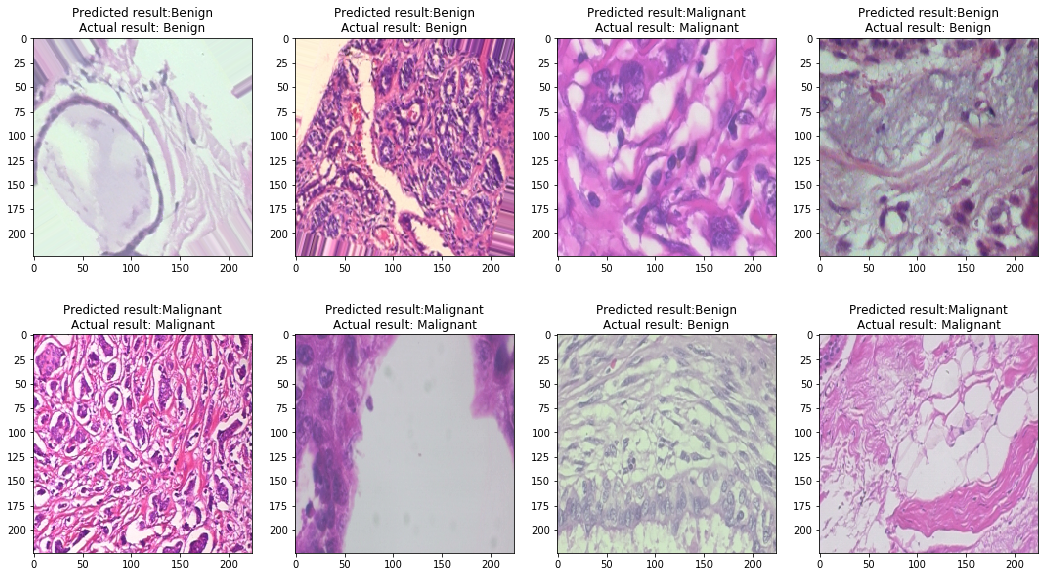

In [30]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()